# Assignment 2: Hybrid Images and Scale-space blob detection

In [1]:
# Libraries you will find useful
import numpy as np
import scipy 
import skimage.io
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Part 1: Hybrid Images

In [152]:
# Crop and align the images such that the objects and their edges are aligned. 
# You are free to use any image editing tool for this and there is no need for code for this step.
from pathlib import Path
# Load cropped and aligned images
src_dir = Path('p1_1')
c1 = skimage.io.imread(src_dir / 'c1_aligned.jpg')
c2 = skimage.io.imread(src_dir / 'c2_aligned.jpg')

In [153]:
# Read aligned input images and convert them to grayscale 
from skimage.color import rgb2gray

c1 = rgb2gray(c1)
c2 = rgb2gray(c2)

from skimage.io import imsave
skimage.io.imsave('c1_gray.jpg', c1*255)
skimage.io.imsave('c2_gray.jpg', c2*255)

Lossy conversion from float64 to uint8. Range [0.9279, 250.04190000000003]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.85, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


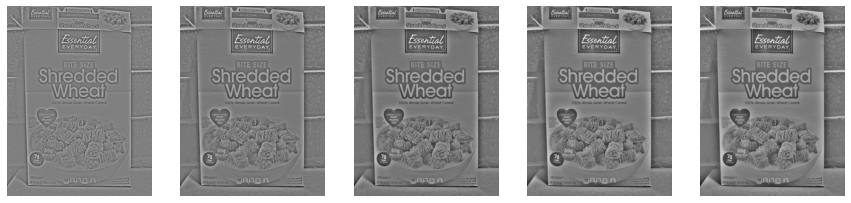

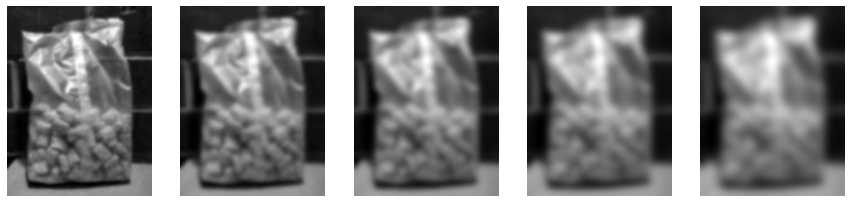

In [154]:
# Apply a high-pass filter on the second image. 
# The paper suggests using an impulse (identity) filter minus a Gaussian filter for this operation.
from scipy.ndimage import gaussian_filter

sigma_list = (3, 5, 7, 9, 11)
save_sigma_compare = True

fig, ax = plt.subplots(1, len(sigma_list), figsize=(15, 5))
for i, sigma in enumerate(sigma_list):
    c1f = c1 - gaussian_filter(c1, sigma=sigma)
    ax[i].imshow(c1f, cmap='gray')
    ax[i].axis('off')

if save_sigma_compare:
    fig.savefig(f'c1_sigmas.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

c1f = c1 - gaussian_filter(c1, sigma=11)

fig, ax = plt.subplots(1, len(sigma_list), figsize=(15, 5))
for i, sigma in enumerate(sigma_list):
    c2f = gaussian_filter(c2, sigma=sigma)
    ax[i].imshow(c2f, cmap='gray')
    ax[i].axis('off')

if save_sigma_compare:
    fig.savefig(f'c2_sigmas.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

c2f = gaussian_filter(c2, sigma=3)

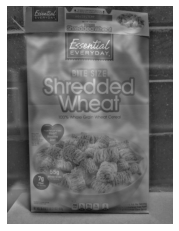

In [156]:
# Add or average the tranformed images to create the hybrid image.
c = c1f + c2f

fig, ax = plt.subplots();
ax.imshow(c, cmap='gray');
ax.axis('off');

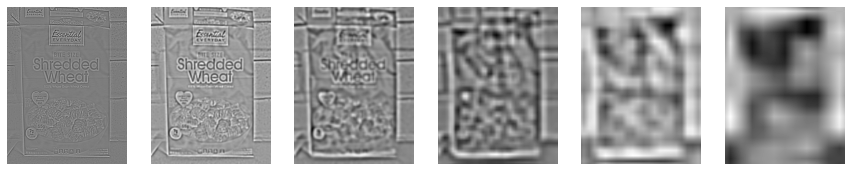

In [166]:
# laplacian pypramid analysis

n_sigma = 6
sigmas = np.logspace(np.log10(1), np.log10(32), n_sigma)

fig, ax = plt.subplots(1, n_sigma, figsize=(15, 5));

for r, (name, im) in enumerate(zip(('c1', 'c2', 'merge'), (c1f, c2f, c))):
    pyramid, sigmas = zip(*list(
        laplacian_pyramid(
            im, 
            max_layer=n_sigma, 
            downscale=sigmas[1]/sigmas[0], 
            sigma=sigmas[0], 
            method='resize', 
            return_sigma=True
        )
    ))

    for i in range(n_sigma):
        ax[i].imshow(pyramid[i], cmap='gray');
        ax[i].axis('off');
    
    fig.savefig(src_dir / f'{name}_pyramid.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

#pyramid0 = np.stack(pyramid0, axis=-1)
#sigmas = np.array(sigmas)

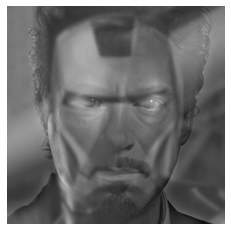

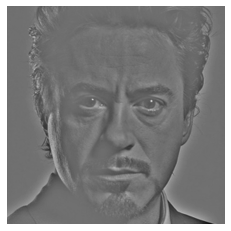

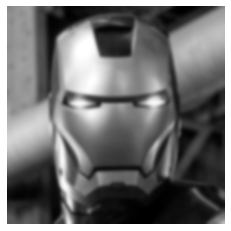

In [115]:
fig, ax = plt.subplots();
ax.imshow(c, cmap='gray');
ax.axis('off');
fig.savefig(src_dir / f'merge.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

fig, ax = plt.subplots();
ax.imshow(c1f, cmap='gray');
ax.axis('off');
fig.savefig(src_dir / f'c1_filtered.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

fig, ax = plt.subplots();
ax.imshow(c2f, cmap='gray');
ax.axis('off');
fig.savefig(src_dir / f'c2_filtered.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

/home/andy/.conda/envs/ece549-mp/lib/python3.8/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 78165 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


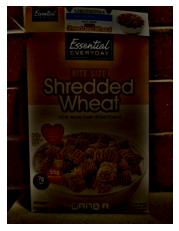

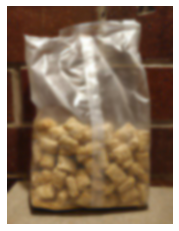

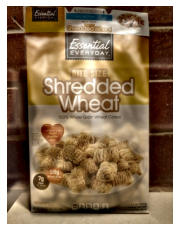

In [151]:
# image fusion, colored version

from pathlib import Path
# Load cropped and aligned images
src_dir = Path('p1_1')
c1 = skimage.io.imread(src_dir / 'c1_aligned.jpg')
c2 = skimage.io.imread(src_dir / 'c2_aligned.jpg')

# Read aligned input images and convert them to grayscale 
from skimage.color import rgb2lab, lab2rgb

c1f = rgb2lab(c1)
c2f = rgb2lab(c2)

c1f[..., 0] = c1f[..., 0] - gaussian_filter(c1f[..., 0], sigma=15)
c2f[..., 0] = gaussian_filter(c2f[..., 0], sigma=3)

c = lab2rgb(c1f) 
fig, ax = plt.subplots();
ax.imshow(c);
ax.axis('off');
fig.savefig(src_dir / f'c1_filtered_color.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

c = lab2rgb(c2f) 
fig, ax = plt.subplots();
ax.imshow(c);
ax.axis('off');
fig.savefig(src_dir / f'c2_filtered_color.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

# create the hybrid image
c = np.zeros_like(c1f)
# merge L
c[..., 0] = c1f[..., 0] + c2f[..., 0]

# normalized intensity for weighting
c1f_norm = (c1f[..., 0] - np.min(c1f[..., 0])) / (np.max(c1f[..., 0]) - np.min(c1f[..., 0]))
c2f_norm = (c2f[..., 0] - np.min(c2f[..., 0])) / (np.max(c2f[..., 0]) - np.min(c2f[..., 0]))


# merge AB by L weighting
for i in (1, 2):
    c[..., i] = c1f[..., i] * c1f_norm/(c1f_norm + c2f_norm) + c2f[..., i] * c2f_norm/(c1f_norm + c2f_norm)

# revert back to RGB
c = lab2rgb(c) 

fig, ax = plt.subplots();
ax.imshow(c);
ax.axis('off');

fig.savefig(src_dir / f'merge_color.jpg', bbox_inches='tight', transparent=True, pad_inches=0)

## Part 2: Scale-space blob detection

In [169]:
# load image and convert it to gray scale
im = skimage.io.imread('p2/butterfly.jpg')
im = rgb2gray(im) # rgb2gray normalize to [0, 1]

In [170]:
# Creating the Laplacian filter
# Pay careful attention to setting the right filter mask size. Hint: Should the filter width be odd or even?

In [171]:
# filtering the image (two implmementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()
from scipy.ndimage.filters import gaussian_laplace
from skimage.transform import resize

def laplacian_pyramid_1(im, max_layer, downscale, sigma):
    """Filter by different gaussian."""
    for _ in range(max_layer):  
        im_l = gaussian_laplace(im, sigma, truncate=6)
        yield im_l * sigma**2, sigma
        sigma *= downscale

def laplacian_pyramid_2(im, max_layer, downscale, sigma):
    """Filter by downsampling."""
    im0 = im.copy()
    shape0, sigma0 = im.shape, sigma
    for _ in range(max_layer):
        out_shape = np.ceil(np.array(im.shape) / downscale)
        
        im_l = gaussian_laplace(im, sigma0, truncate=6)
        im_l = resize(im_l, shape0)
        yield im_l * sigma0**2, sigma

        im = resize(im, out_shape)
        sigma *= downscale

def laplacian_pyramid(
    im, max_layer=-1, downscale=2, sigma=None, method='resize', return_sigma=True
):
    if max_layer == -1:
        max_layer = int(np.ceil(np.log(np.max(im.shape)) / np.log(downscale)))
    
    downscale = float(downscale)
    
    if sigma is None:
        # covers >99% of distribution
        sigma = 2 * downscale / 6.  
    else:
        sigma = float(sigma)

    try:
        func = {
            'sigma': laplacian_pyramid_1,
            'resize': laplacian_pyramid_2
        }[method]
    except KeyError:
        raise ValueError(f"unknown method '{method}'")
    for level in func(im, max_layer, downscale, sigma):
        yield level if return_sigma else level[0]

layer 0, sigma=2.0000
.. diff_max=0.0000
=====
layer 1, sigma=4.0000
.. diff_max=0.0032
=====
layer 2, sigma=8.0000
.. diff_max=0.0043
=====
layer 3, sigma=16.0000
.. diff_max=0.0029
=====
layer 4, sigma=32.0000
.. diff_max=0.0036
=====


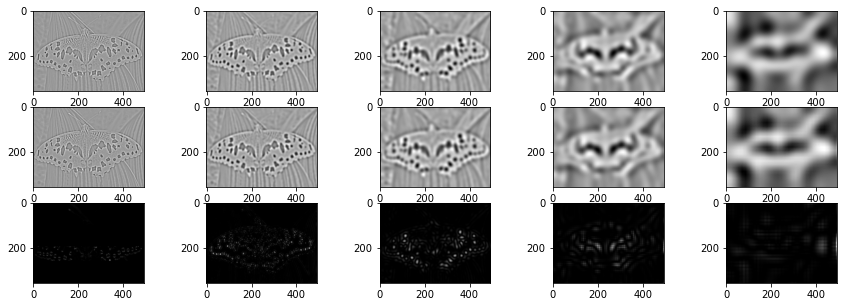

In [172]:
# sanity check, compare different pyramid implementation
from numpy.testing import assert_array_almost_equal_nulp, assert_allclose

max_layer = 5
downscale = 2
pyramids = tuple(
    laplacian_pyramid(
        im, 
        max_layer=max_layer, 
        downscale=downscale, 
        sigma=2,
        method=method, 
        return_sigma=True
    )
    for method in ('sigma', 'resize')
)
fix, ax = plt.subplots(3, max_layer, figsize=(15, 5))
for i, layers in enumerate(zip(*pyramids)):
    (im_sig, s_sig), (im_res, s_res) = layers
    
    assert_array_almost_equal_nulp(s_sig, s_res)
    print(f'layer {i}, sigma={s_sig:.4f}')

    ax[0, i].imshow(im_sig, cmap='gray')
    ax[1, i].imshow(im_res, cmap='gray')
    im_diff = np.abs(im_sig-im_res)**2
    print(f'.. diff_max={np.max(im_diff):.4f}')
    ax[2, i].imshow(im_diff, cmap='gray')
    try:
        assert_allclose(im_sig, im_res, atol=0.5, verbose=False)
    except AssertionError as err:
        print(f'.. failed\n{err}')

    print('=====')
    
plt.show()

In [173]:
min_sigma = 2
max_sigma = 50
n_sigma = 10

scale = np.logspace(np.log10(min_sigma), np.log10(max_sigma), n_sigma)

In [222]:
from scipy.ndimage import rank_filter

def blob_detection(
    im, 
    min_sigma=1, 
    max_sigma=50, 
    n_sigma=10, 
    method='resize', 
    threshold=0.2,
    show_pyramid=False
):
    sigmas = np.logspace(np.log10(min_sigma), np.log10(max_sigma), n_sigma)
    pyramid0, sigmas = zip(*list(
        laplacian_pyramid(
            im, 
            max_layer=n_sigma, 
            downscale=sigmas[1]/sigmas[0], 
            sigma=sigmas[0], 
            method=method, 
            return_sigma=True
        )
    ))
    pyramid0 = np.stack(pyramid0, axis=-1)
    sigmas = np.array(sigmas)

    # flip sign, we are actually working with min
    pyramid0 = -pyramid0

    # non-maximal supression along each scale
    pyramid = rank_filter(
        pyramid0, 
        -1, 
        footprint=np.ones((3,) * (pyramid0.ndim-1) + (1,))
    )    
    # the threshold
    scale_max = np.max(pyramid, axis=-1)

    if show_pyramid:
        # DEBUG
        fig, ax = plt.subplots()
        ax.imshow(scale_max)
        # DEBUG
        fig, ax = plt.subplots(1, n_sigma, figsize=(15, 5))
        for i in range(n_sigma):
            ax[i].imshow(pyramid[..., i], cmap='gray')

    pyramid = pyramid0 * (pyramid0 == scale_max[..., np.newaxis])

    maxima = np.where(pyramid > threshold)
    maxima = np.stack(maxima).T

    # replace index with actual sigma
    sigmas = sigmas[maxima[:, -1]]
    maxima = np.hstack([maxima[:, :-1], sigmas[:, np.newaxis]])
    return maxima

In [175]:
# nonmaximum suppression in scale space
# you may find functions scipy.ndimage.filters.rank_filter or scipy.ndimage.filters.generic_filter useful

In [216]:
# To display the detected regions as circle
from matplotlib.patches import Circle

def show_all_circles(
    image, cx, cy, rad, color='r', figsize=(8, 6), show_title=False, show_axes=False):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    if show_title:
        plt.title(f'{len(cx)} circles')
    if not show_axes:
        plt.axis('off')
    plt.show()

    return fig

In [177]:
class StopExecution(Exception):
    """Stop current and subsequent cells quietly."""
    def _render_traceback_(self):
        pass

In [178]:
import skimage.data
import skimage.io
skimage.io.imsave('coffee.jpg', skimage.data.coffee())

method=sigma, t=3.1871617900000273s
(1068, 3)


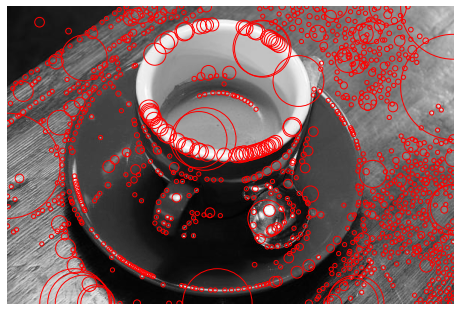

method=resize, t=0.5440801499997179s
(1474, 3)


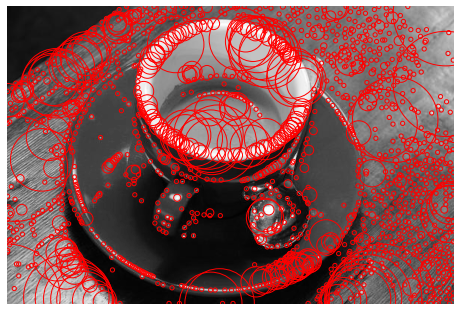

In [234]:
# baseline time test
from timeit import default_timer as timer
from pathlib import Path

src_path = Path('p2') / 'coffee.jpg'
im = skimage.io.imread(src_path)
if im.ndim == 1:
    im /= np.max(im)
else:
    im = rgb2gray(im) # rgb2gray normalize to [0, 1]

n_repeat = 10
for method in ('sigma', 'resize'):
    start = timer()
    for _ in range(n_repeat):
        maxima = blob_detection(
            im, min_sigma=2, max_sigma=50, n_sigma=32, method=method, threshold=0.01
        )
    end = timer()
    print(f'method={method}, t={(end-start)/n_repeat}s')
    print(maxima.shape)

    # turn sigma to radius
    maxima[:, -1] *= np.sqrt(2)
    # unzip columns
    cy, cx, r = maxima.T

    h = show_all_circles(im, cx, cy, r)

    dst_path = src_path.stem + f'_blob_{method}.jpg'
    h.savefig(dst_path, bbox_inches='tight', transparent=True, pad_inches=0)

min(sigma)=2
(743, 3)


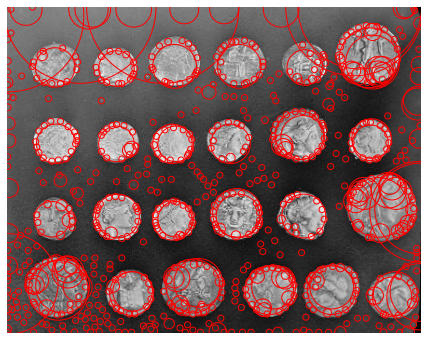

min(sigma)=4
(244, 3)


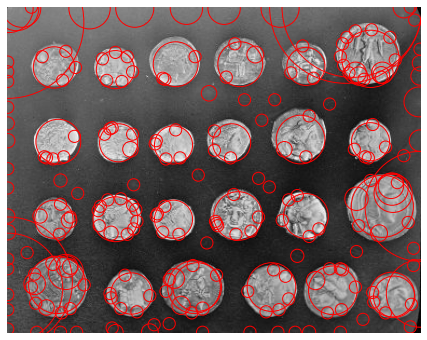

min(sigma)=8
(54, 3)


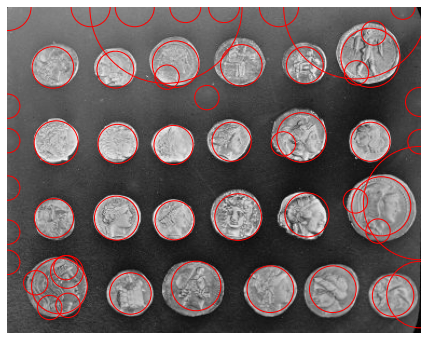

In [235]:
# parameter search
from pathlib import Path

src_path = Path('p2') / 'coins.jpg'
im = skimage.io.imread(src_path)
if im.ndim == 1:
    im /= np.max(im)
else:
    im = rgb2gray(im) # rgb2gray normalize to [0, 1]

for min_sigma in (2, 4, 8):
    maxima = blob_detection(
        im, 
        min_sigma=min_sigma, 
        max_sigma=50, 
        n_sigma=32, 
        method='resize', 
        threshold=0.01
    )
    print(f'min(sigma)={min_sigma}')
    print(maxima.shape)

    # turn sigma to radius
    maxima[:, -1] *= np.sqrt(2)
    # unzip columns
    cy, cx, r = maxima.T

    h = show_all_circles(im, cx, cy, r)

    dst_path = src_path.stem + f'_min{min_sigma}.jpg'
    h.savefig(dst_path, bbox_inches='tight', transparent=True, pad_inches=0)

In [225]:
from skimage.feature import structure_tensor

def blob_detection_2(
    im, 
    min_sigma=1, 
    max_sigma=50, 
    n_sigma=10, 
    method='resize', 
    threshold=0.2,
    alpha=0.05,
    show_pyramid=False,
    show_harris=False
):
    sigmas = np.logspace(np.log10(min_sigma), np.log10(max_sigma), n_sigma)
    pyramid0, sigmas = zip(*list(
        laplacian_pyramid(
            im, 
            max_layer=n_sigma, 
            downscale=sigmas[1]/sigmas[0], 
            sigma=sigmas[0], 
            method=method, 
            return_sigma=True
        )
    ))
    pyramid0 = np.stack(pyramid0, axis=-1)
    sigmas = np.array(sigmas)

    # flip sign, we are actually working with min
    pyramid0 = -pyramid0

    # non-maximal supression along each scale
    pyramid = rank_filter(
        pyramid0, 
        -1, 
        footprint=np.ones((3,) * (pyramid0.ndim-1) + (1,))
    )    
    # the threshold
    scale_max = np.max(pyramid, axis=-1)

    if show_pyramid:
        # DEBUG
        fig, ax = plt.subplots()
        ax.imshow(scale_max)
        # DEBUG
        fig, ax = plt.subplots(1, n_sigma, figsize=(15, 5))
        for i in range(n_sigma):
            ax[i].imshow(pyramid[..., i], cmap='gray')

    
    harris = []
    for i, sigma in enumerate(sigmas):
        Arr, Arc, Acc = structure_tensor(im, sigma, order='rc')

        det = Arr*Acc - Arc**2
        tr = Arr + Acc
        R = det - alpha * tr**2

        harris.append(R)
    
    if show_harris:
        fig, ax = plt.subplots(1, n_sigma, figsize=(15, 5))
        for i, R in enumerate(harris):
            ax[i].imshow(R, cmap='gray')
    
    harris = np.stack(harris, axis=-1)
    
    # threshold by scale max
    pyramid = pyramid0 * (pyramid0 == scale_max[..., np.newaxis])
    # reject edges
    pyramid *= harris > 0
    
    maxima = np.where(pyramid > threshold)
    maxima = np.stack(maxima).T

    # replace index with actual sigma
    sigmas = sigmas[maxima[:, -1]]
    maxima = np.hstack([maxima[:, :-1], sigmas[:, np.newaxis]])
    return maxima

min(sigma)=8
(1160, 3)


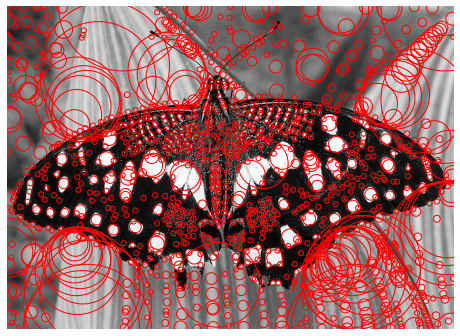

min(sigma)=8
(865, 3)


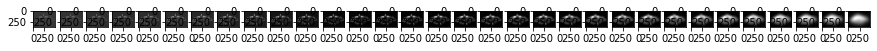

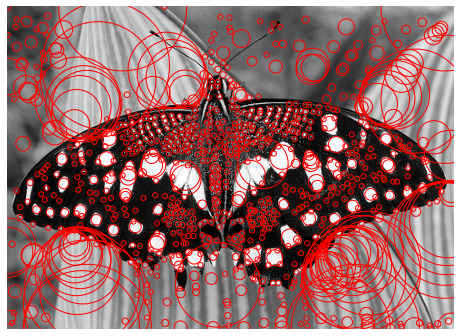

In [237]:
# with corner response
from pathlib import Path
from functools import partial

src_path = Path('p2') / 'butterfly.jpg'
im = skimage.io.imread(src_path)
if im.ndim == 1:
    im /= np.max(im)
else:
    im = rgb2gray(im) # rgb2gray normalize to [0, 1]

common_kwargs = {
    'min_sigma': 2, 
    'max_sigma': 50, 
    'n_sigma': 32, 
    'method': 'resize', 
    'threshold': 0.01,
    'show_pyramid': False, 
}

naive_blob = partial(
    blob_detection,
    **common_kwargs
)

blob_with_harris = partial(
    blob_detection_2,
    alpha=0.05,
    show_harris=True,
    **common_kwargs
) 

for impl, func in zip(('naive', 'harris'), (naive_blob, blob_with_harris)):
    maxima = func(im)
    print(f'min(sigma)={min_sigma}')
    print(maxima.shape)

    # turn sigma to radius
    maxima[:, -1] *= np.sqrt(2)
    # unzip columns
    cy, cx, r = maxima.T

    h = show_all_circles(im, cx, cy, r)

    dst_path = src_path.stem + f'_impl-{impl}.jpg'
    h.savefig(dst_path, bbox_inches='tight', transparent=True, pad_inches=0)